In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random
import os
np.random.seed(5)
random.seed(5)
import pandas as pd
import time
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.metrics import average_precision_score

2022-04-07 17:34:54.495421: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
import sys
sys.path.insert(1, '/cluster/home/omineeva/ResMiCo')
from resmico import contig_reader
from resmico import utils
from resmico import models_fl as Models
from resmico.commands.evaluate import parse_args
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import seaborn as sns
colors = ['#4daf4a', '#e41a1c',  '#377eb8', '#984ea3', '#ff7f00', '#ffff33']
sns.set(font_scale=1.2, style="whitegrid", palette=sns.color_palette(colors))

In [5]:
project_path = '/cluster/home/omineeva/global_projects/projects/projects2019-contig_quality/'


data_path = project_path + \
            'data/v2/resmico-sm/GTDBr202_n9k_novel-family_test/features/'

stats_file = project_path + \
            '/data/v2/resmico-sm/n9k_train_allavail/' + \
            'stats_cov.json'

model_name = project_path + '/Outputs/mc_epoch_60_aucPR_0.701_1rep_wis_frq1_simcrop_model.h5'

In [6]:
custom_obj = {'class_recall_0': utils.class_recall_0, 'class_recall_1': utils.class_recall_1,
              'GlobalMaskedMaxPooling1D': Models.GlobalMaskedMaxPooling1D}


model = load_model(model_name, custom_objects=custom_obj)

2022-04-07 17:34:59.890039: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-07 17:34:59.891441: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-07 17:35:00.173527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:85:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-04-07 17:35:00.176403: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:86:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-04-07 17:35:00.179264: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:89:00.0 name: Tesl

In [8]:
joint_line = ''

joint_line += ' --features'
features_set17=" ref_base num_query_A num_query_C num_query_G num_query_T num_SNPs num_proper_Match num_orphans_Match mean_al_score_Match coverage stdev_insert_size_Match max_insert_size_Match mean_mapq_Match min_mapq_Match"
features_D = " ref_base num_query_A num_query_C num_query_G num_query_T num_SNPs num_proper_Match num_orphans_Match mean_al_score_Match coverage stdev_insert_size_Match mean_mapq_Match"
features_upcov=" mean_al_score_Match mean_mapq_Match num_orphans_Match mean_insert_size_Match min_al_score_Match num_proper_Match min_insert_size_Match num_proper_SNP coverage"
features_shap=" num_query_A num_query_C num_query_G num_query_T mean_mapq_Match stdev_al_score_Match mean_al_score_Match mean_insert_size_Match coverage min_al_score_Match num_SNPs min_insert_size_Match num_proper_Match num_orphans_Match"
joint_line += features_shap

joint_line += ' --feature-files-path '
joint_line += data_path

joint_line += ' --stats-file '
joint_line += stats_file

joint_line += ' --mask-padding'
joint_line += ' --binary-data '

joint_line += ' --n-procs=4'

In [9]:
args = parse_args().parse_args(joint_line.split())

In [10]:
args

Namespace(model='/cluster/home/omineeva/ResMiCo/resmico/model/fl_all_model.h5', batch_size=100, sdepth=None, rich=None, filter10=False, rep10=False, method_pred='chunks', min_len=1000, mem_lim=500000, window=5000, v1=False, longdir=False, embeddings=False, emb_ind=0, binary_data=True, gpu_eval_mem_gb=3.0, val_ind_f=None, chunks=False, log_level='INFO', no_cython=False, seed=12, n_procs=4, max_len=10000, save_path='.', save_name='resmico', feature_files_path='/cluster/home/omineeva/global_projects/projects/projects2019-contig_quality/data/v2/resmico-sm/GTDBr202_n9k_novel-family_test/features/', feature_file_table='', technology='all-asmbl', big_data=False, features=['num_query_A', 'num_query_C', 'num_query_G', 'num_query_T', 'mean_mapq_Match', 'stdev_al_score_Match', 'mean_al_score_Match', 'mean_insert_size_Match', 'coverage', 'min_al_score_Match', 'num_SNPs', 'min_insert_size_Match', 'num_proper_Match', 'num_orphans_Match'], stats_file='/cluster/home/omineeva/global_projects/projects/p

In [11]:
if args.mask_padding:
    convoluted_size = Models.construct_convolution_lambda(model)
else:  # when not padding, the convoluted size is unused
    convoluted_size = lambda len, pad: 0

In [12]:
reader = contig_reader.ContigReader(args.feature_files_path, args.features, args.n_procs, args.chunks,
                                    args.no_cython, args.stats_file, args.min_len)

(array([277178.,   6161.,   3918.,   2916.,   2440.,   2070.,   1916.,
          1732.,   1564.,   1319.]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ]),
 <BarContainer object of 10 artists>)

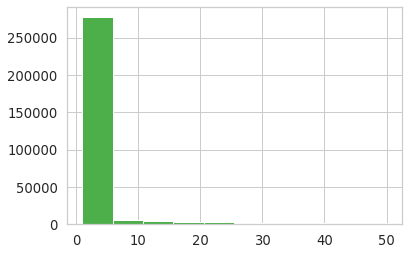

In [13]:
#Length of "misassemled" piece

bp_len = []
for ind, contig in enumerate(reader.contigs):
    if contig.misassembly > 0: 
        for intbp in contig.breakpoints:
            lowbp, highbp = intbp[0], intbp[1]
            bp_len.append(highbp-lowbp+1)
            
plt.hist(bp_len)

In [14]:
#to filter contigs from the range
minlen = 7000
maxlen = 9000

# for resmico to produce scores
window = 1000
step = 100

#will be used to aggregate scores
numwindows = 5

In [15]:
#pipeline

# design function that scan with a window and aggregate scores
# do grid search with parameters: for best parameters report auc on the test set

In [16]:
#select contigs with a certain length 

sel_idx = []
for ind, contig in enumerate(reader.contigs):
    if contig.length > minlen and contig.length < maxlen:# and contig.misassembly > 0: 
        sel_idx.append(ind)

random.shuffle(sel_idx)
#use 20% of the data to make predictions faster
sel_idx = sel_idx[:len(sel_idx)//5]

#split them in 2 part
train_idx, test_idx = sel_idx[:len(sel_idx)//2], sel_idx[len(sel_idx)//2:]

print(len(train_idx), len(test_idx))

10098 10099


In [17]:
train_labels = [1*(reader.contigs[ind].misassembly > 0) for ind in train_idx ]
test_labels = [1*(reader.contigs[ind].misassembly > 0) for ind in test_idx ]
print(np.mean(train_labels), np.mean(test_labels))

0.022677757971875618 0.02227943360728785


In [18]:
def tf_data(predict_data):
    data_iter = lambda: (s for s in predict_data)
    predict_data_tf = tf.data.Dataset.from_generator(
        data_iter,
        output_signature=(
            (tf.TensorSpec(shape=(None, None, len(predict_data.expanded_feature_names)), dtype=tf.float32),
             tf.TensorSpec(shape=(None, None), dtype=tf.bool)),
            tf.TensorSpec(shape=(None), dtype=tf.bool)
        ))
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    predict_data_tf = predict_data_tf.with_options(options)
    
    return predict_data_tf

# compute AUPRC when the whole contig is given as input

In [19]:
#give the whole contig as input
predict_data = Models.BinaryDatasetEval(reader, train_idx, args.features, 20000, 10000,
                                        int(args.gpu_eval_mem_gb * 1e9 * 0.8), cache_results=False,
                                        show_progress=False, convoluted_size=convoluted_size, pad_to_max_len=False)
predict_data_tf = tf_data(predict_data)



eval_data_flat_y = model.predict(x=predict_data_tf,
                                 workers=args.n_procs,
                                 use_multiprocessing=True,
                                 max_queue_size=max(args.n_procs, 10),
                                 verbose=1)

#no need to group if contigs shorter than window
train_fulllen_preds = predict_data.group(eval_data_flat_y, max) 

average_precision_score(train_labels, train_fulllen_preds)

2022-04-07 17:37:42.373005: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-07 17:37:42.373501: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2195130000 Hz
2022-04-07 17:37:43.105994: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-04-07 17:37:45.800795: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


34/34 [==============================] - 95s 3s/step


0.4372643237438185

# look at 50 misassembled contigs

In [20]:
idx_pos50 = [ind for ind in train_idx if reader.contigs[ind].misassembly > 0][:50]

In [21]:
predict_data = Models.BinaryDatasetEval(reader, idx_pos50, args.features, window, step,
                                        int(args.gpu_eval_mem_gb * 1e9 * 0.8), cache_results=False,
                                        show_progress=False, convoluted_size=convoluted_size,
                                        pad_to_max_len=False)
predict_data_tf = tf_data(predict_data)

flat_y = model.predict(x=predict_data_tf,
                                 workers=args.n_procs,
                                 use_multiprocessing=True,
                                 max_queue_size=max(args.n_procs, 10),
                                 verbose=1)
predicted_arr = predict_data.group(flat_y, 'arr')

1/1 [==============================] - 1s 1s/step


In [22]:
#give the whole contig as input
predict_data = Models.BinaryDatasetEval(reader, idx_pos50, args.features, 20000, 10000,
                                        int(args.gpu_eval_mem_gb * 1e9 * 0.8), cache_results=False,
                                        show_progress=False, convoluted_size=convoluted_size, pad_to_max_len=False)
predict_data_tf = tf_data(predict_data)
eval_data_flat_y = model.predict(x=predict_data_tf,
                                 workers=args.n_procs,
                                 use_multiprocessing=True,
                                 max_queue_size=max(args.n_procs, 10),
                                 verbose=1)
#no need to group if contigs shorter than window
idx_pos50_preds = predict_data.group(eval_data_flat_y, max) 

1/1 [==============================] - 0s 368ms/step


0


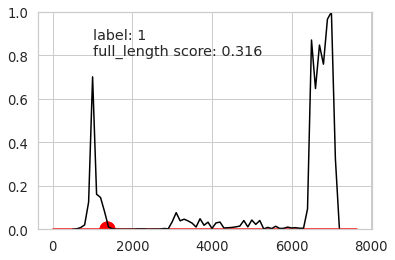

1


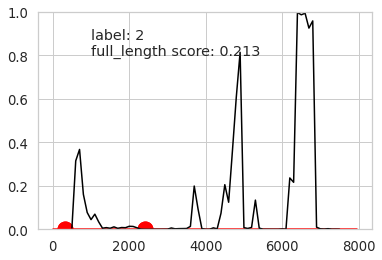

2


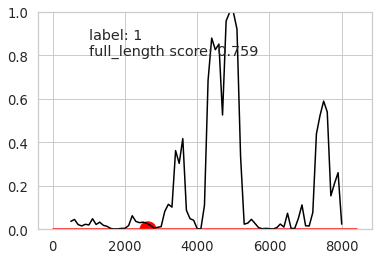

3


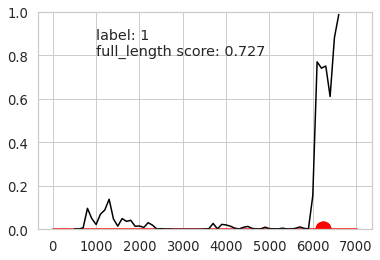

4


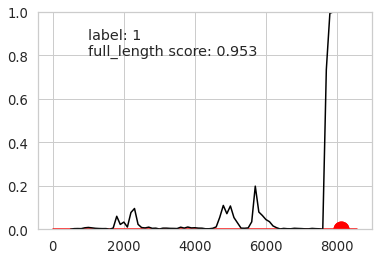

5


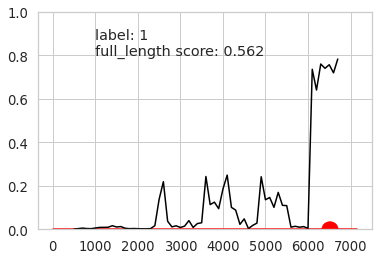

6


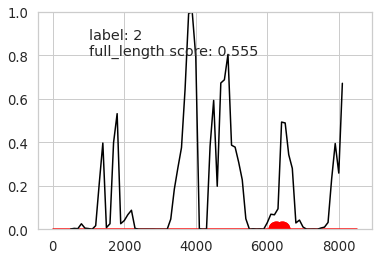

7


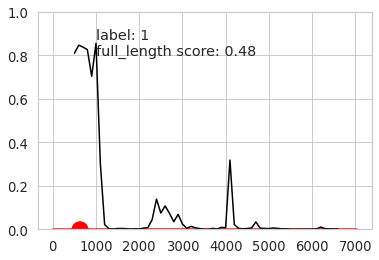

8


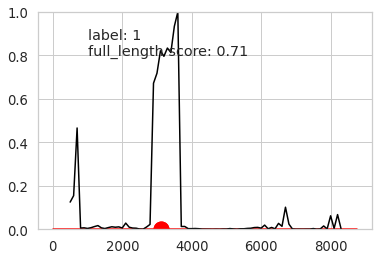

9


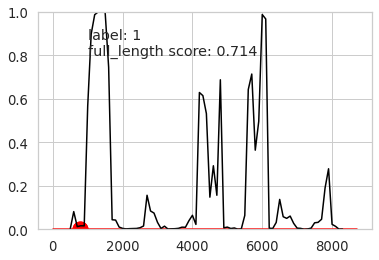

10


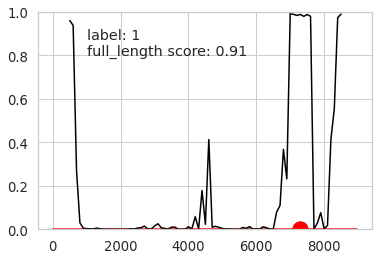

11


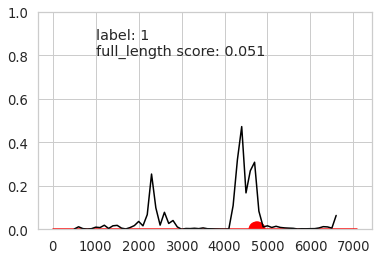

12


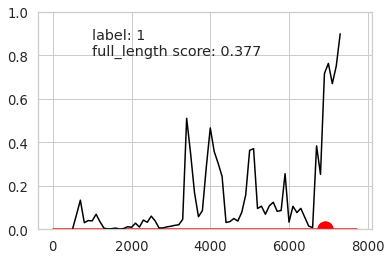

13


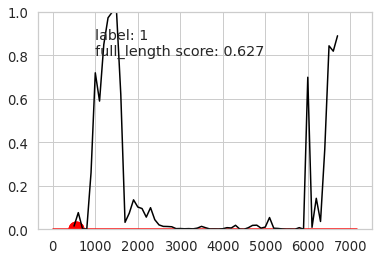

14


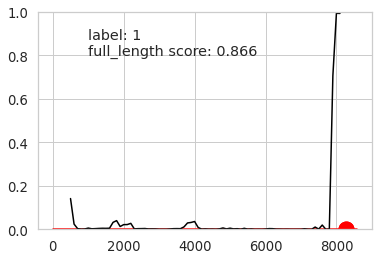

15


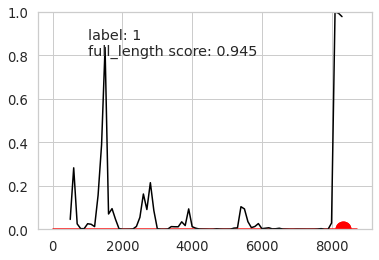

16


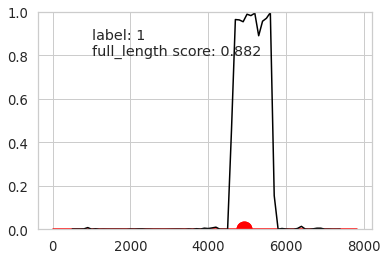

17


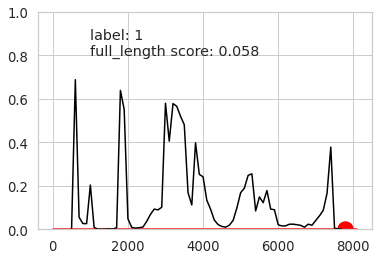

18


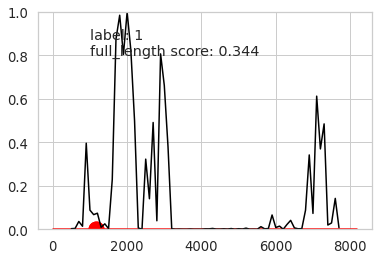

19


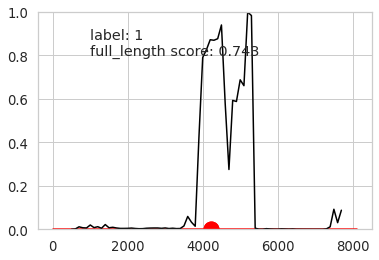

20


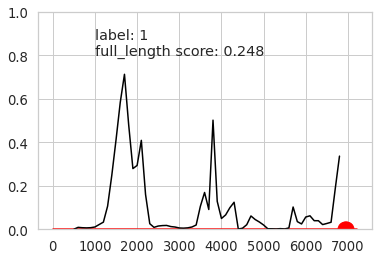

21


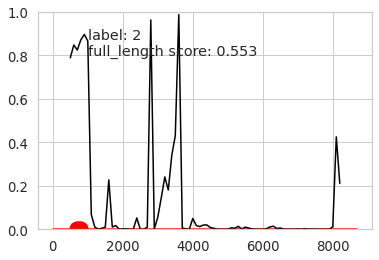

22


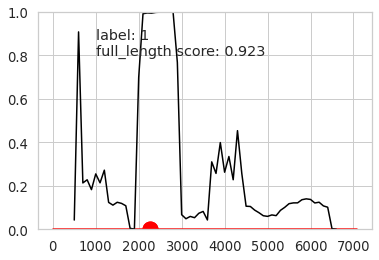

23


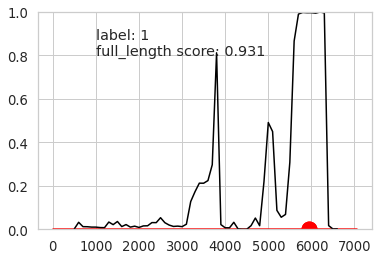

24


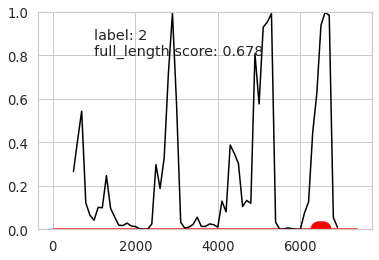

25


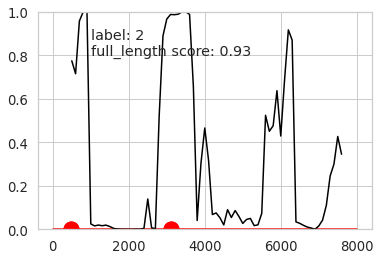

26


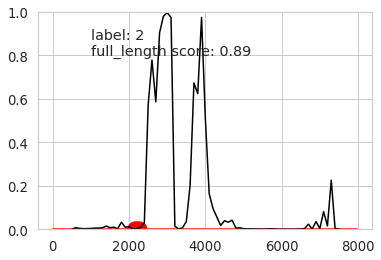

27


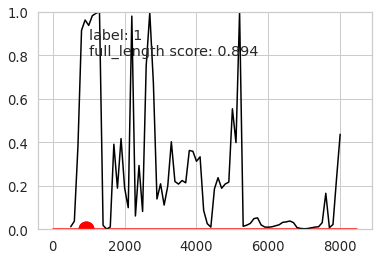

28


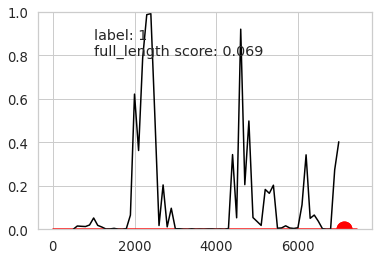

29


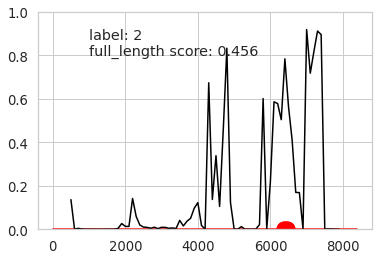

30


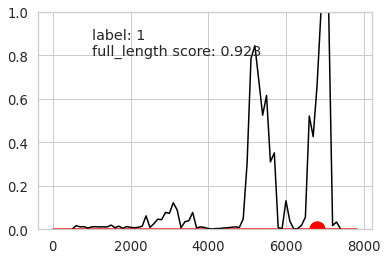

31


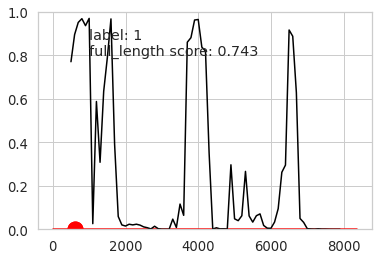

32


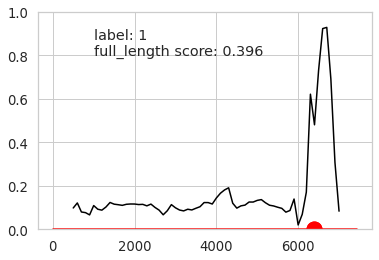

33


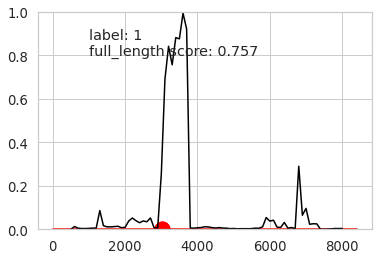

34


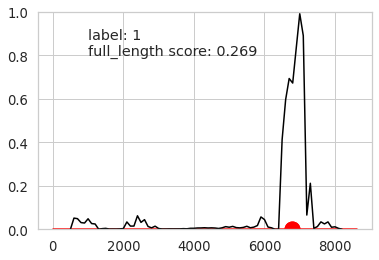

35


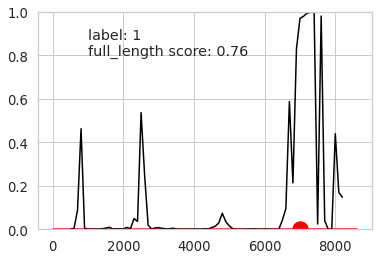

36


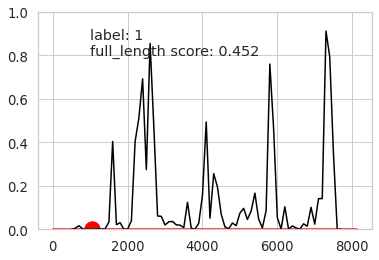

37


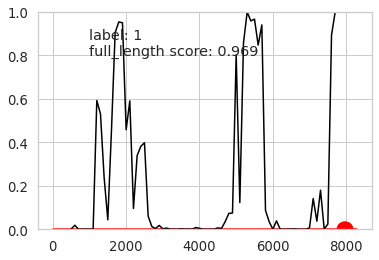

38


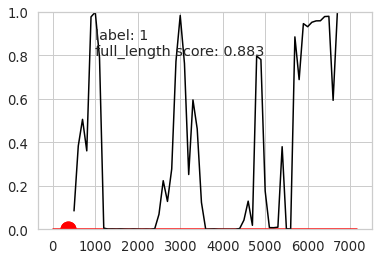

39


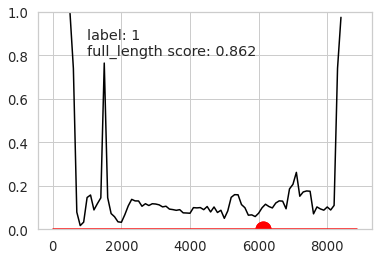

40


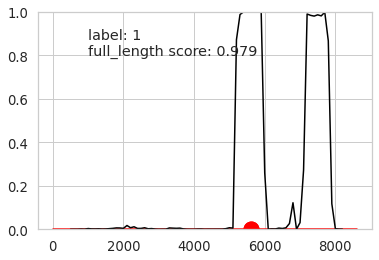

41


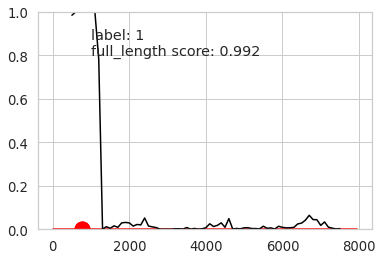

42


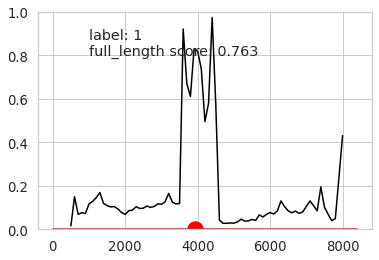

43


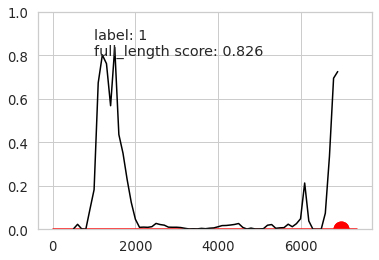

44


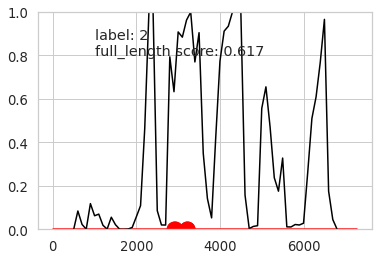

45


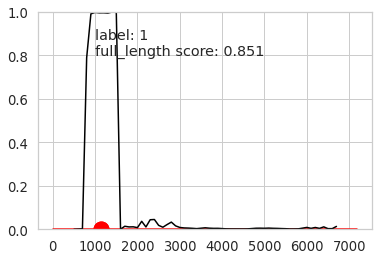

46


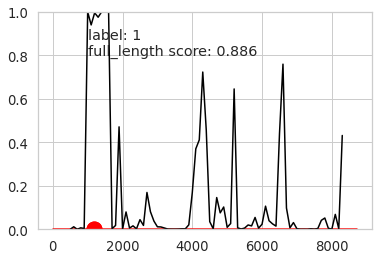

47


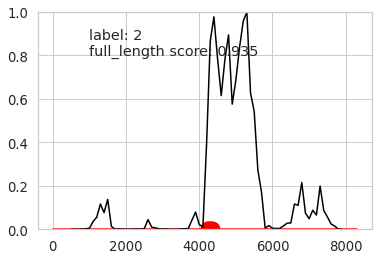

48


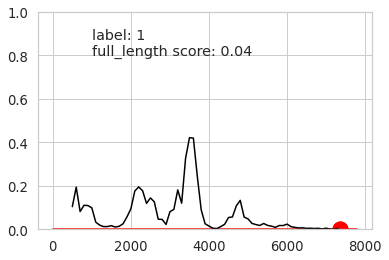

49


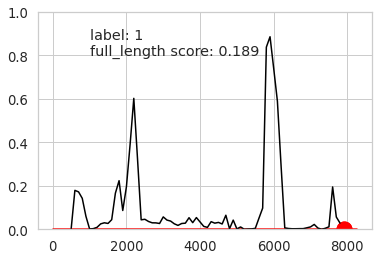

In [23]:
i=0
for ind in idx_pos50:
    print(i)
    cont = reader.contigs[ind]
    if cont.misassembly > 0:
        c = 'r'
    else:
        c = 'g'
    plt.plot((0, cont.length), (0,0), c=c)
    
    
    if cont.misassembly > 0:
        for intbp in cont.breakpoints:
            lowbp, highbp = intbp[0], intbp[1]
            plt.plot((lowbp, highbp+1), (0,0), 'ro--', linewidth=2, markersize=15)
            
    plt.plot(np.arange(len(predicted_arr[i]))*step+window/2,
                predicted_arr[i], color='k')
    
    plt.ylim(0,1)
    plt.text(1000, 0.8, 
            'label: ' + str(reader.contigs[ind].misassembly) + \
            '\n'+ 'full_length score: ' + str(round(idx_pos50_preds[i], 3)))
    plt.show()
    i+=1

# look at 50 correctly assembled contigs

In [24]:
idx_neg50 = [ind for ind in train_idx if reader.contigs[ind].misassembly == 0][:50]

In [25]:
predict_data = Models.BinaryDatasetEval(reader, idx_neg50, args.features, window, step,
                                        int(args.gpu_eval_mem_gb * 1e9 * 0.8), cache_results=False,
                                        show_progress=False, convoluted_size=convoluted_size,
                                        pad_to_max_len=False)
predict_data_tf = tf_data(predict_data)

flat_y = model.predict(x=predict_data_tf,
                                 workers=args.n_procs,
                                 use_multiprocessing=True,
                                 max_queue_size=max(args.n_procs, 10),
                                 verbose=1)
predicted_arr = predict_data.group(flat_y, 'arr')

1/1 [==============================] - 1s 1s/step


In [26]:
#give the whole contig as input
predict_data = Models.BinaryDatasetEval(reader, idx_neg50, args.features, 20000, 10000,
                                        int(args.gpu_eval_mem_gb * 1e9 * 0.8), cache_results=False,
                                        show_progress=False, convoluted_size=convoluted_size, pad_to_max_len=False)
predict_data_tf = tf_data(predict_data)
flat_y = model.predict(x=predict_data_tf,
                                 workers=args.n_procs,
                                 use_multiprocessing=True,
                                 max_queue_size=max(args.n_procs, 10),
                                 verbose=1)
#no need to group if contigs shorter than window
idx_neg50_preds = predict_data.group(flat_y, max) 

1/1 [==============================] - 0s 339ms/step


0


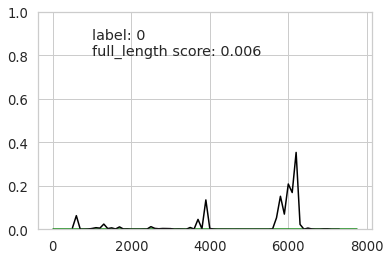

1


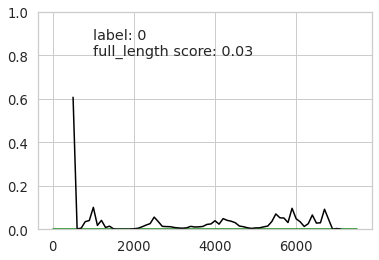

2


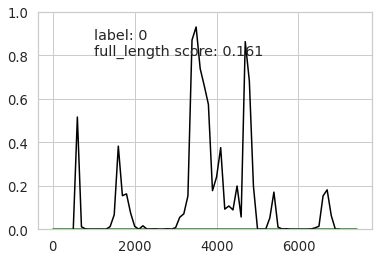

3


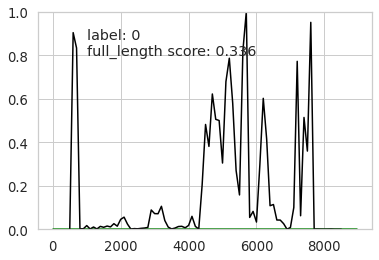

4


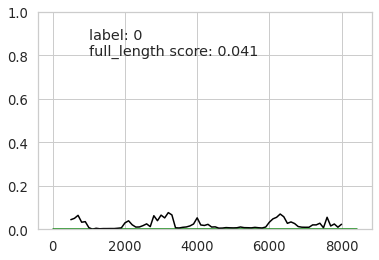

5


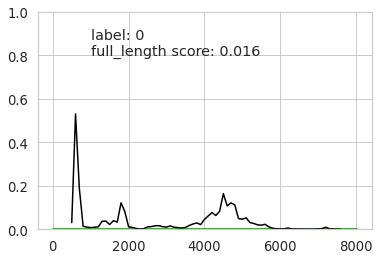

6


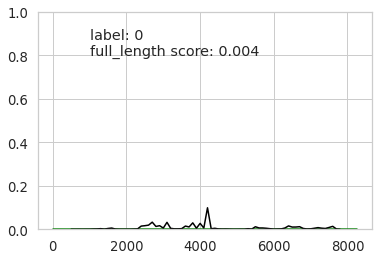

7


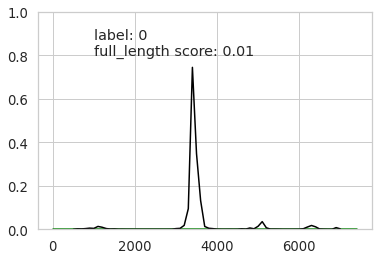

8


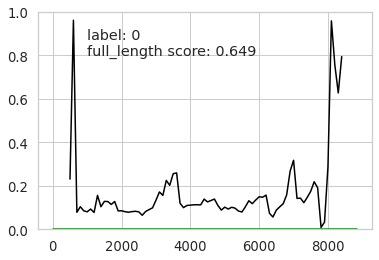

9


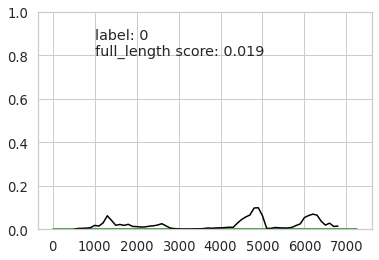

10


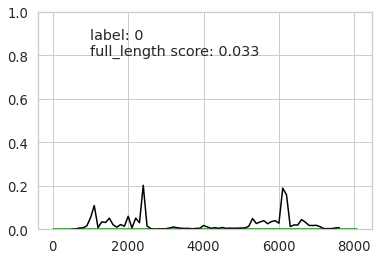

11


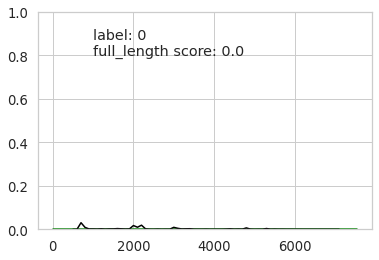

12


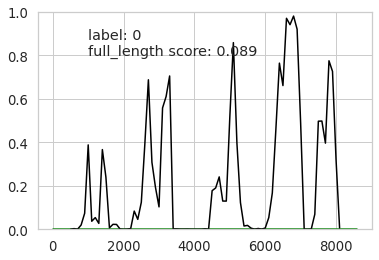

13


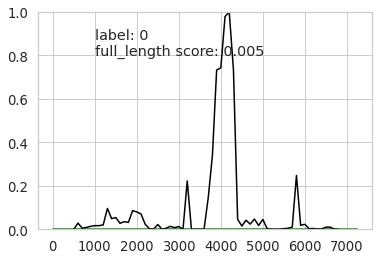

14


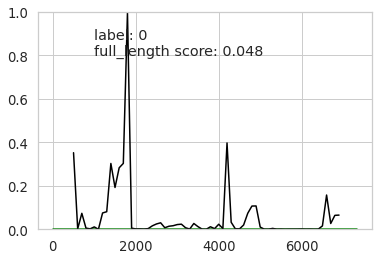

15


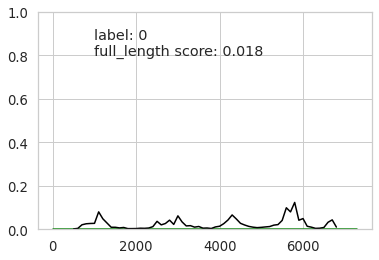

16


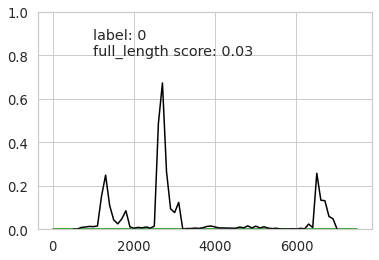

17


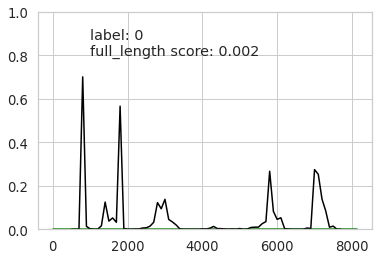

18


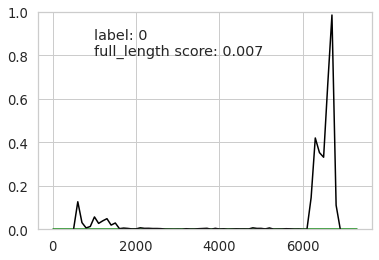

19


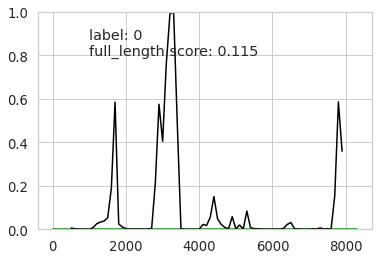

20


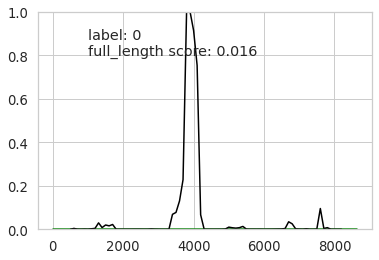

21


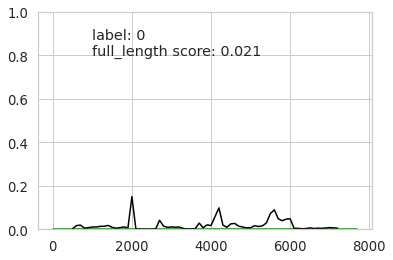

22


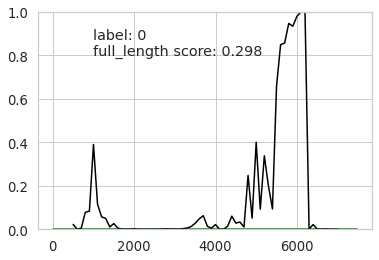

23


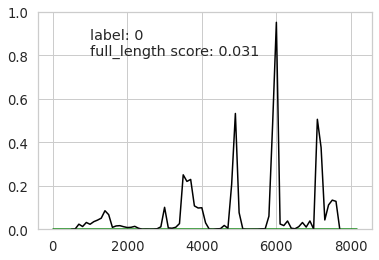

24


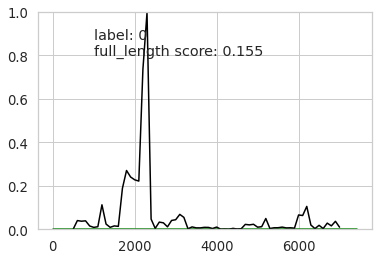

25


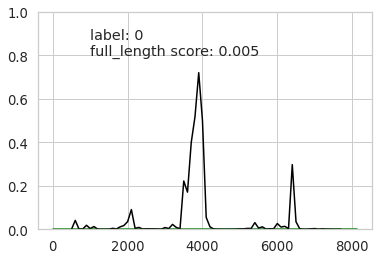

26


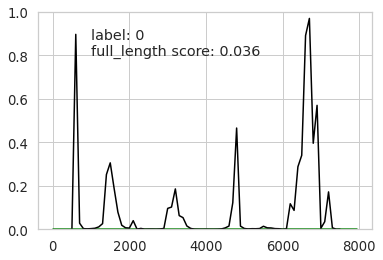

27


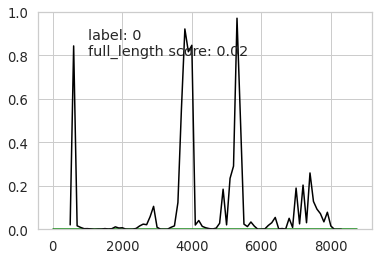

28


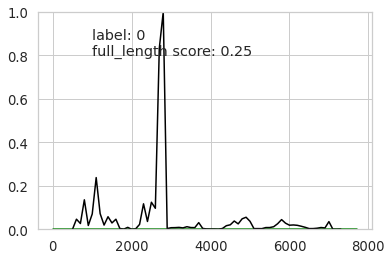

29


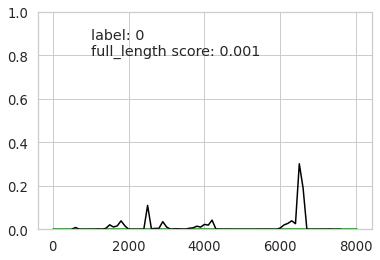

30


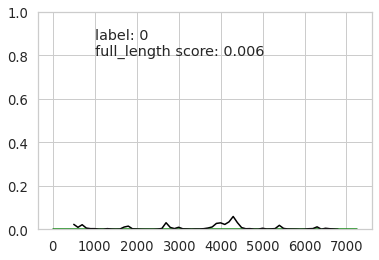

31


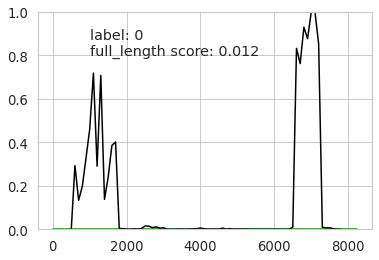

32


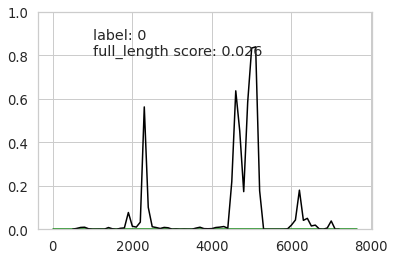

33


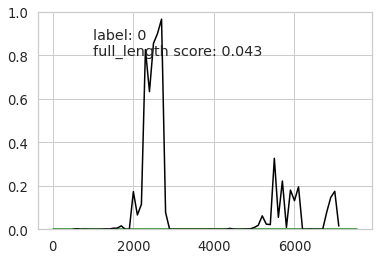

34


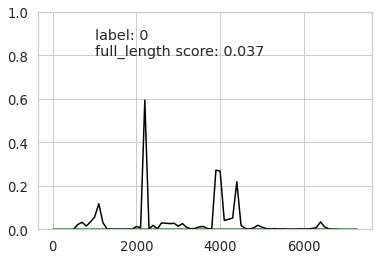

35


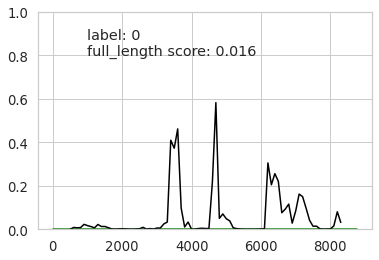

36


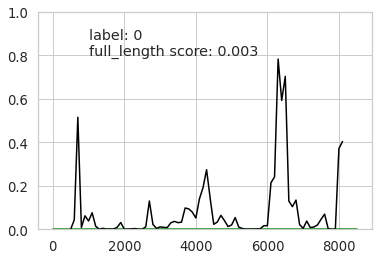

37


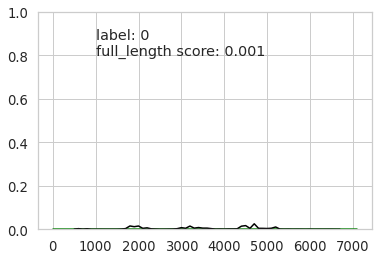

38


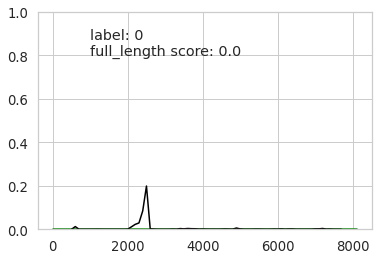

39


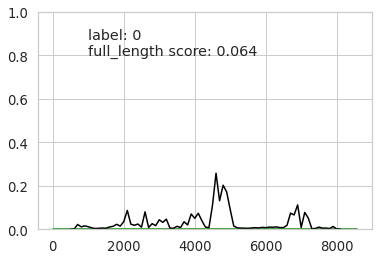

40


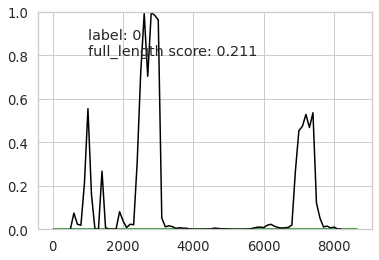

41


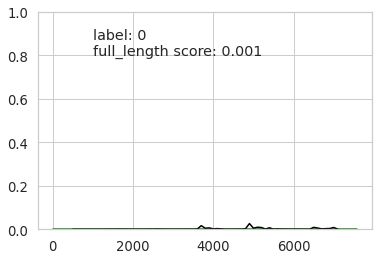

42


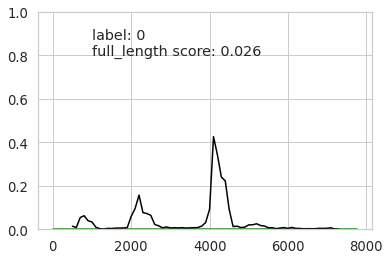

43


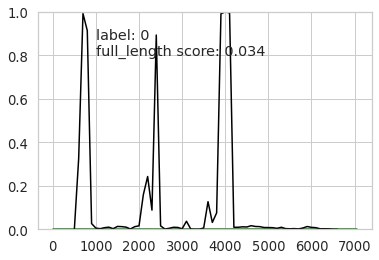

44


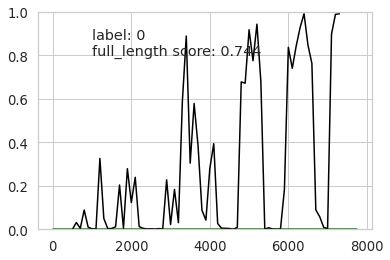

45


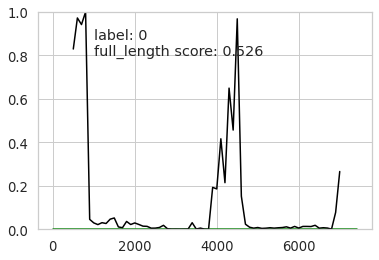

46


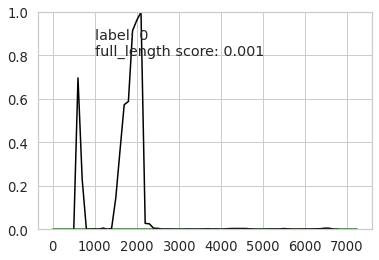

47


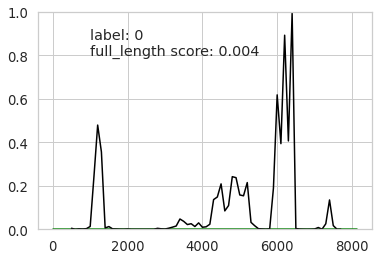

48


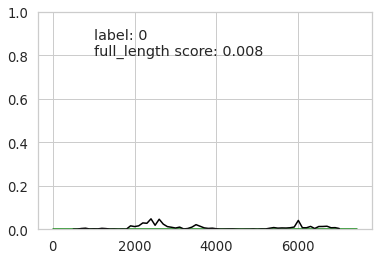

49


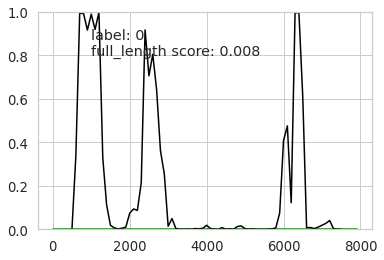

In [27]:
i=0
for ind in idx_neg50:
    print(i)
    cont = reader.contigs[ind]
    if cont.misassembly > 0:
        c = 'r'
    else:
        c = 'g'
    plt.plot((0, cont.length), (0,0), c=c)
    
    
    if cont.misassembly > 0:
        for intbp in cont.breakpoints:
            lowbp, highbp = intbp[0], intbp[1]
            plt.plot((lowbp, highbp+1), (0,0), 'ro--', linewidth=2, markersize=15)
            
    plt.plot(np.arange(len(predicted_arr[i]))*step+window/2,
                predicted_arr[i], color='k')
    
    plt.ylim(0,1)
    plt.text(1000, 0.8, 
            'label: ' + str(reader.contigs[ind].misassembly) + \
            '\n'+ 'full_length score: ' + str(round(idx_neg50_preds[i], 3)))
    plt.show()
    i+=1

# design function to predict using small sliding window

In [28]:
def aggregate_windows(preds, numwindows):
    #contig score is an average of top numwindows scores
    out = []
    for cont in preds:
        num = min(numwindows, len(cont)-1)
        temp = np.partition(-cont, num)
        score = np.mean(-temp[:num])
        out.append(score)
    return out    

In [29]:
for window, step in [(1000, 100), (1000, 500), (1000, 950),
                    (2000, 100), (2000, 300), (2000, 1500),
                    (3000, 1000)]:

    predict_data = Models.BinaryDatasetEval(reader, train_idx, args.features, window, step,
                                            int(args.gpu_eval_mem_gb * 1e9 ), cache_results=False,
                                            show_progress=False, convoluted_size=convoluted_size,
                                            pad_to_max_len=False)
    predict_data_tf = tf_data(predict_data)
    flat_y = model.predict(x=predict_data_tf,
                                     workers=args.n_procs,
                                     use_multiprocessing=True,
                                     max_queue_size=max(args.n_procs, 10),
                                     verbose=1)
    predicted_arr = predict_data.group(flat_y, 'arr')
    
    
    for numwindows in [1, 3, 5, 10]:
        aggr = aggregate_windows(predicted_arr, numwindows)
        print('AUPRC {:.3f}, window {}, step {}, numwindows {}'.format(
            average_precision_score(train_labels, aggr), window, step, numwindows))

34/34 [==============================] - 173s 5s/step
AUPRC 0.140, window 1000, step 100, numwindows 1
AUPRC 0.157, window 1000, step 100, numwindows 3
AUPRC 0.189, window 1000, step 100, numwindows 5
AUPRC 0.165, window 1000, step 100, numwindows 10
34/34 [==============================] - 58s 2s/step
AUPRC 0.147, window 1000, step 500, numwindows 1
AUPRC 0.144, window 1000, step 500, numwindows 3
AUPRC 0.135, window 1000, step 500, numwindows 5
AUPRC 0.124, window 1000, step 500, numwindows 10
34/34 [==============================] - 53s 2s/step
AUPRC 0.047, window 1000, step 950, numwindows 1
AUPRC 0.096, window 1000, step 950, numwindows 3
AUPRC 0.092, window 1000, step 950, numwindows 5
AUPRC 0.101, window 1000, step 950, numwindows 10
34/34 [==============================] - 404s 12s/step
AUPRC 0.219, window 2000, step 100, numwindows 1
AUPRC 0.234, window 2000, step 100, numwindows 3
AUPRC 0.234, window 2000, step 100, numwindows 5
AUPRC 0.238, window 2000, step 100, numwindows 